In [1]:
# install
!pip install -q novosparc
!pip install -q altair

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import numpy as np
import os 
from matplotlib.pyplot import figure
import anndata
import novosparc
import altair as alt
from scipy.spatial.distance import cdist, squareform, pdist
from scipy.stats import ks_2samp
from scipy.stats import pearsonr
import omnipath
%matplotlib inline

/opt/conda/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Dataset 1: Reconstruction and Visualiation of Drosophila Dataset (Figure 3)

In [3]:
# Reading expression data to scanpy AnnData (cells x genes)
data_dir = '../../data/GraphComm_Input//Drosophila/'
data_path = os.path.join(data_dir, 'matrix.csv')
dataset = sc.read(data_path,delimiter=",",first_column_names=True).T
#dataset = sc.read("/data/intercell_GraphComm_Input/Drosophila/matrix.csv",delimiter=",",first_column_names=True)
gene_names = dataset.var.index.tolist()

num_cells, num_genes = dataset.shape # 1297 cells x 8924 genes

print('number of cells: %d' % num_cells)
print('number of genes: %d' % num_genes)

number of cells: 5835
number of genes: 8443


/opt/conda/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/opt/conda/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [4]:
#preprocess
sc.pp.normalize_per_cell(dataset)
sc.pp.log1p(dataset)

In [5]:
atlas_dir = '../../data/raw_data/Drosophila/bdtnp/'
target_space_path = os.path.join(atlas_dir, 'geometry.txt')
locations = pd.read_csv(target_space_path, sep=' ')
num_locations = 3039
locations_apriori = locations[:num_locations][['xcoord', 'zcoord']].values

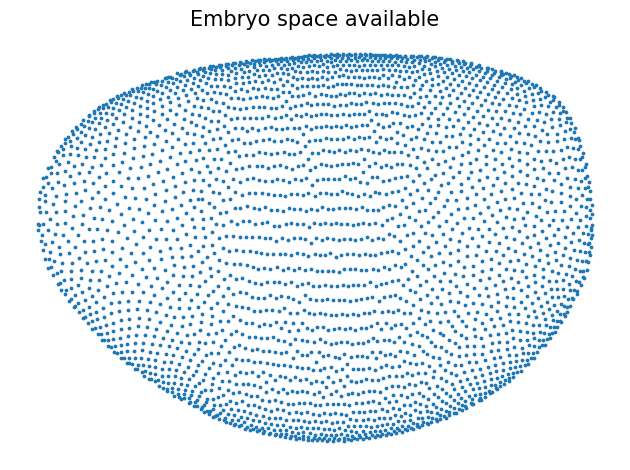

In [6]:
tit_size = 15
dpi = 100
#fig, ax = plt.subplots(1,1, figsize=(12,3), dpi=dpi)

plt.scatter(locations_apriori[:, 0], locations_apriori[:, 1], s=3)
#ax[1].scatter(locations_from_image[:, 0], locations_from_image[:, 1], s=3)
#ax[2].scatter(locations_circle[:, 0], locations_circle[:, 1], s=3)

plt.title('Embryo space available', size=tit_size)
#ax[1].set_title('Prior shape without exact locations', size=tit_size)
#ax[2].set_title('No prior knowledge of target space', size=tit_size)

plt.axis('off')
#ax[1].axis('off')
#ax[2].axis('off')

plt.tight_layout()
plt.show()

## Reconstruct the tissue and visualize average gene expression

In [7]:
dge_rep = None # a representation of cells gene expression
sc.pp.highly_variable_genes(dataset)
is_var_gene = dataset.var['highly_variable']
var_genes = list(is_var_gene.index[is_var_gene])

# alternative 1: variable expressed genes representation
dge_rep = dataset.to_df()[var_genes]

# alternative 2: pca representation
sc.pp.pca(dataset)
# dge_rep = pd.DataFrame(dataset.obsm['X_pca'])

# construct tissue object
tissue = novosparc.cm.Tissue(dataset=dataset, locations=locations_apriori)
num_neighbors_s = num_neighbors_t = 5

# tissue.setup_reconstruction(num_neighbors_s=num_neighbors_s, num_neighbors_t=num_neighbors_t)

# alternative: since we don't have the atlas assumption, we can also setup only the smooth costs.
tissue.setup_smooth_costs(dge_rep=dge_rep, num_neighbors_s=num_neighbors_s, num_neighbors_t=num_neighbors_t)
tissue.reconstruct(alpha_linear=0, epsilon=5e-3)
sdge = tissue.sdge
dataset_reconst = sc.AnnData(pd.DataFrame(sdge.T, columns=dataset.var.index.tolist()))
dataset_reconst.obsm['spatial'] = locations_apriori

Setting up for reconstruction ... 

/opt/conda/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


done ( 3.01 seconds )
Reconstructing spatial information with 0 markers: 1584 cells and 3039 locations ... 
Trying with epsilon: 5.00e-03


<ipython-input-7-90810128c7a2>:23: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  dataset_reconst = sc.AnnData(pd.DataFrame(sdge.T, columns=dataset.var.index.tolist()))
/opt/conda/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/opt/conda/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [20]:
results = pd.read_csv("../../data/GraphComm_Output/Drosophila/CCI.csv",index_col=0)
#results = pd.merge(results,intercell,left_on=["Src","Dst"],right_on=["source","target"])
#results = results.head(1000)

In [21]:
resource = pd.read_csv("../../data/LR_database/consensus_Omnipath.csv")

In [23]:
results[results["Src"].isin(resource["source"].tolist()) & results["Dst"].isin(resource["target"].tolist())]

,Src,Dst,Prob
25099,GRP,LAMP1,0.982765
8038,HDC,LAMP1,0.982268
25224,GRP,ART1,0.982040
18190,PCNA,LAMP1,0.981927
8163,HDC,ART1,0.981543
...,...,...,...
39184,CUBN,PDE1C,0.627575
11125,FST,PDE1C,0.627572
2101,WNT2,PDE1C,0.627565
33121,WNT4,PDE1C,0.627544


In [33]:
categories = omnipath.requests.Intercell.get()

44.7MB [00:00, 56.6MB/s]


## top ranked interaction

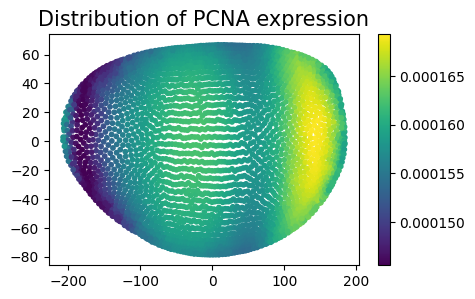

In [18]:
dataset = dataset_reconst
color = ["PCNA"]
title=None
size_x=None
size_y=None
pt_size=10
tit_size=15
dpi=100

new_matrix = pd.DataFrame(dataset_reconst.X)
new_matrix.columns = dataset.var.index.tolist()
new_matrix.index = dataset.obs.index.tolist()
new_matrix = new_matrix.loc[:,~new_matrix.columns.duplicated()].copy()
new_matrix["avg"]=new_matrix.sum(axis=1)
new_dataset = anndata.AnnData(new_matrix)
new_dataset.obsm = dataset.obsm
dataset = new_dataset


title = color if title is None else title
ncolor = len(color)
per_row = 3
per_row = ncolor if ncolor < per_row else per_row
nrows = int(np.ceil(ncolor / per_row))
size_x = 5 * per_row if size_x is None else size_x
size_y = 3 * nrows if size_y is None else size_y
fig, axs = plt.subplots(nrows, per_row, figsize=(size_x, size_y), dpi=dpi)
xy = dataset.obsm['spatial']
x = xy[:, 0]
y = xy[:, 1] if xy.shape[1] > 1 else np.ones_like(x)
for i, g in enumerate(color):
    if g in dataset.var_names:
        values = dataset[:, g].X
    elif g in dataset.obs.columns:
        values = dataset.obs[g]
    else:
        continue
    indices = np.where(values > np.mean(values))[0]
    plot = plt.scatter(x, y, c=np.array(values), s=pt_size)
    plt.title(f"Distribution of {color[0]} expression", size=tit_size)
    plt.colorbar(plot)
plt.show()

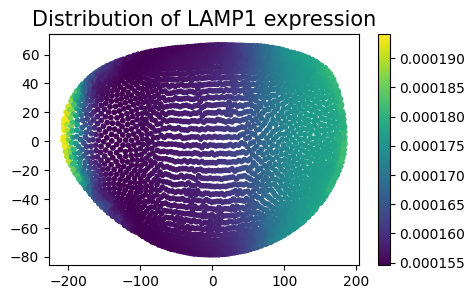

In [19]:
dataset = dataset_reconst
color = ["LAMP1"]
title=None
size_x=None
size_y=None
pt_size=10
tit_size=15
dpi=100

new_matrix = pd.DataFrame(dataset_reconst.X)
new_matrix.columns = dataset.var.index.tolist()
new_matrix.index = dataset.obs.index.tolist()
new_matrix = new_matrix.loc[:,~new_matrix.columns.duplicated()].copy()
new_matrix["avg"]=new_matrix.sum(axis=1)
new_dataset = anndata.AnnData(new_matrix)
new_dataset.obsm = dataset.obsm
dataset = new_dataset


title = color if title is None else title
ncolor = len(color)
per_row = 3
per_row = ncolor if ncolor < per_row else per_row
nrows = int(np.ceil(ncolor / per_row))
size_x = 5 * per_row if size_x is None else size_x
size_y = 3 * nrows if size_y is None else size_y
fig, axs = plt.subplots(nrows, per_row, figsize=(size_x, size_y), dpi=dpi)
xy = dataset.obsm['spatial']
x = xy[:, 0]
y = xy[:, 1] if xy.shape[1] > 1 else np.ones_like(x)
for i, g in enumerate(color):
    if g in dataset.var_names:
        values = dataset[:, g].X
    elif g in dataset.obs.columns:
        values = dataset.obs[g]
    else:
        continue
    indices = np.where(values > np.mean(values))[0]
    plot = plt.scatter(x, y, c=np.array(values), s=pt_size)
    plt.title(f"Distribution of {color[0]} expression", size=tit_size)
    plt.colorbar(plot)
plt.show()

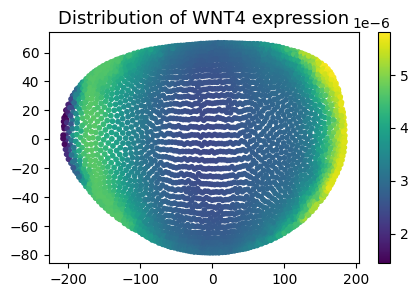

In [24]:
dataset = dataset_reconst
color = ["WNT4"]
title=None
size_x=None
size_y=None
pt_size=10
tit_size=15
dpi=100

new_matrix = pd.DataFrame(dataset_reconst.X)
new_matrix.columns = dataset.var.index.tolist()
new_matrix.index = dataset.obs.index.tolist()
new_matrix = new_matrix.loc[:,~new_matrix.columns.duplicated()].copy()
new_matrix["avg"]=new_matrix.sum(axis=1)
new_dataset = anndata.AnnData(new_matrix)
new_dataset.obsm = dataset.obsm
dataset = new_dataset


title = color if title is None else title
ncolor = len(color)
per_row = 3
per_row = ncolor if ncolor < per_row else per_row
nrows = int(np.ceil(ncolor / per_row))
size_x = 5 * per_row if size_x is None else size_x
size_y = 3 * nrows if size_y is None else size_y
fig, axs = plt.subplots(nrows, per_row, figsize=(size_x, size_y), dpi=dpi)
xy = dataset.obsm['spatial']
x = xy[:, 0]
y = xy[:, 1] if xy.shape[1] > 1 else np.ones_like(x)
for i, g in enumerate(color):
    if g in dataset.var_names:
        values = dataset[:, g].X
    elif g in dataset.obs.columns:
        values = dataset.obs[g]
    else:
        continue
    indices = np.where(values > np.mean(values))[0]
    plot = plt.scatter(x, y, c=np.array(values), s=pt_size)
    plt.title(f"Distribution of {color[0]} expression", size=13)
    plt.colorbar(plot)
#plt.tight_layout()
plt.show()

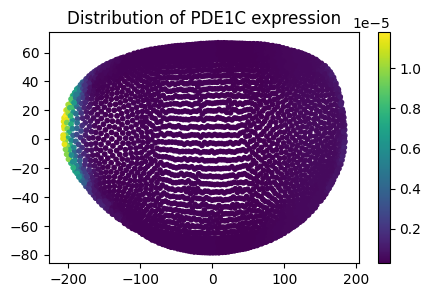

In [25]:
dataset = dataset_reconst
color = ["PDE1C"]
title=None
size_x=None
size_y=None
pt_size=10
tit_size=15
dpi=100

new_matrix = pd.DataFrame(dataset_reconst.X)
new_matrix.columns = dataset.var.index.tolist()
new_matrix.index = dataset.obs.index.tolist()
new_matrix = new_matrix.loc[:,~new_matrix.columns.duplicated()].copy()
new_matrix["avg"]=new_matrix.sum(axis=1)
new_dataset = anndata.AnnData(new_matrix)
new_dataset.obsm = dataset.obsm
dataset = new_dataset


title = color if title is None else title
ncolor = len(color)
per_row = 3
per_row = ncolor if ncolor < per_row else per_row
nrows = int(np.ceil(ncolor / per_row))
size_x = 5 * per_row if size_x is None else size_x
size_y = 3 * nrows if size_y is None else size_y
fig, axs = plt.subplots(nrows, per_row, figsize=(size_x, size_y), dpi=dpi)
xy = dataset.obsm['spatial']
x = xy[:, 0]
y = xy[:, 1] if xy.shape[1] > 1 else np.ones_like(x)
for i, g in enumerate(color):
    if g in dataset.var_names:
        values = dataset[:, g].X
    elif g in dataset.obs.columns:
        values = dataset.obs[g]
    else:
        continue
    indices = np.where(values > np.mean(values))[0]
    plot = plt.scatter(x, y, c=np.array(values), s=pt_size)
    plt.title(f"Distribution of {color[0]} expression", size=12)
    plt.colorbar(plot)
plt.show()

# Dataset 2: Mouse brain dataset (Figure 4)

In [26]:
input_data=pd.read_csv("../../data/GraphComm_Output/Mouse/CCI.csv")

In [27]:
truth = pd.read_csv("../../data/raw_data/Mouse/truth_interactions.csv")[["Ligand","Receptor"]]

In [28]:
truth["Ligand"] = [i.upper() for i in truth["Ligand"].tolist()]
truth["Receptor"] = [i.upper() for i in truth["Receptor"].tolist()]

In [29]:
intercell = pd.read_csv("../../data/LR_database/intercell_Omnipath.csv")

In [31]:
input_data = input_data[input_data["Src"].isin(intercell["source_genesymbol"])]

In [32]:
input_data = input_data[input_data["Dst"].isin(intercell["target_genesymbol"])]

In [33]:
random_list = []
for i in range(1,101):
    random_list.append(pd.read_csv(f"/data/random_data/Mouse/candidate_Mouse_{i}_random.csv",index_col=0))

In [34]:
random_list = [i.drop_duplicates() for i in random_list]

In [35]:
random_list = [i[["Src","Dst","Prob"]] for i in random_list]

In [36]:
random_list = [i.sort_values("Prob",ascending=False) for i in random_list]

In [37]:
new_random_list = []
for i in random_list:
    i.columns = ["Src","Dst","Prob"]
    new_random_list.append(i)

In [38]:
random_list = new_random_list

In [39]:
random_list = [i[["Src","Dst","Prob"]] for i in random_list]

In [40]:
random_list = [i[i["Src"].isin(intercell["source_genesymbol"])] for i in random_list]

In [41]:
random_list = [i[i["Dst"].isin(intercell["target_genesymbol"])] for i in random_list]

In [42]:
random_list = [i.head(1000) for i in random_list]

In [43]:
random_dfs = random_list

In [44]:
important_ligands = truth["Ligand"].unique().tolist()
important_receptors = truth["Receptor"].unique().tolist()

In [45]:
input_data_ = input_data

In [46]:
graphcomm_LR_list = []
for i in range(5,101,5):
    temp= input_data.head(i)
    ligands=[1 if i in important_ligands else 0 for i in temp["Src"].tolist()]
    receptors=[1 if i in important_receptors else 0 for i in temp["Dst"].tolist()]
    graphcomm_LR_list.append((np.sum(ligands)+np.sum(receptors))/(i*2))
random_LR_list = []
for i in random_dfs:
    sub_random = i
    sub_random_list = []
    for j in range(5,101,5):
        temp= sub_random.head(j)
        ligands=[1 if i in important_ligands else 0 for i in temp["Src"].tolist()]
        receptors=[1 if i in important_receptors else 0 for i in temp["Dst"].tolist()]
        sub_random_list.append((np.sum(ligands)+np.sum(receptors))/(j*2))
    random_LR_list.append(sub_random_list)

In [47]:
mean_random_LR_list = list(np.mean(random_LR_list,axis=0))

In [48]:
graphcomm_LR_list = [0] + graphcomm_LR_list
mean_random_LR_list = [0] + mean_random_LR_list

Text(0, 0.5, 'Number of unique ligands/receptors')

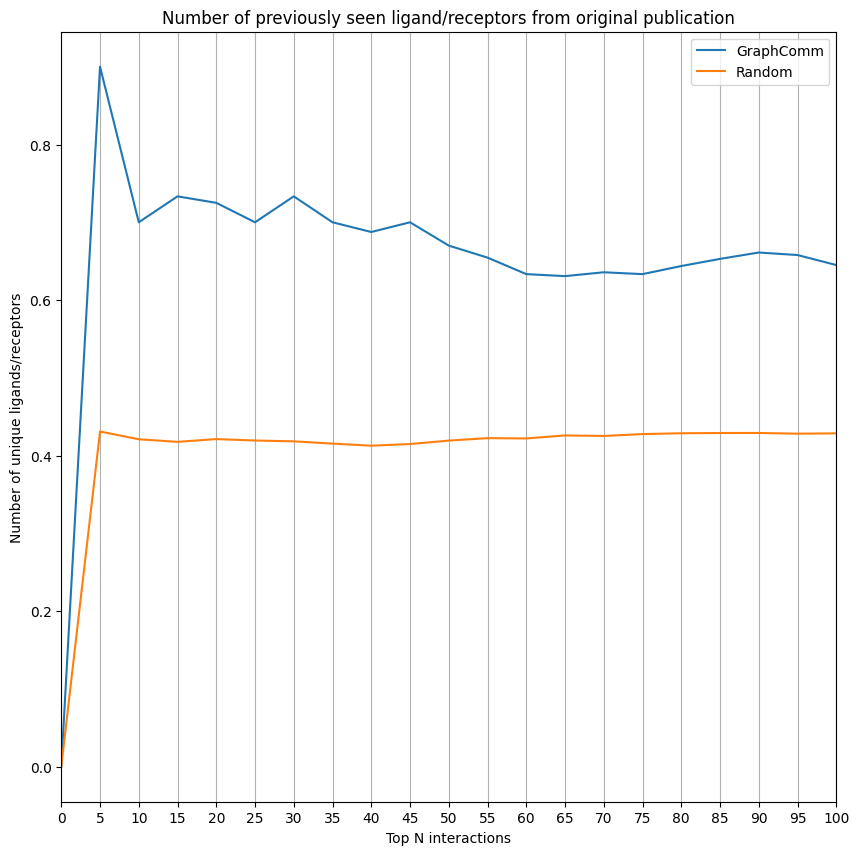

In [49]:
figure(figsize=(10,10))

plt.plot(range(0,101,5),graphcomm_LR_list,label="GraphComm")
plt.plot(range(0,101,5),mean_random_LR_list,label="Random")
plt.grid(axis = 'x')
plt.xticks(range(0,101,5))
plt.xlim((0,100))
#plt.ylim((0,10))
plt.legend()
plt.title("Number of previously seen ligand/receptors from original publication")
plt.xlabel("Top N interactions")
plt.ylabel("Number of unique ligands/receptors")
#plt.savefig("/results/cdf.png")

# Dataset 3:scRNA PC9 cell line dataset with drug treatment - change comparison datasets to generate pre/post or biological replicate overlap (Figure 5)

### load datasets

In [50]:
day0=pd.read_csv("../../data/GraphComm_Output/Pre_Post/Day0/CCI.csv",index_col=0)
day7_rep1=pd.read_csv("../../data/GraphComm_Output/Pre_Post/Day7_1/CCI.csv",index_col=0)
day7_rep2=pd.read_csv("../../data/GraphComm_Output/Pre_Post/Day7_2/CCI.csv",index_col=0)

In [51]:
Omnipath_database = pd.read_csv("../../data/LR_database/intercell_Omnipath.csv",index_col=0)

In [52]:
Omnipath_database.columns = ["from","to","sources"]

### only retain, within each dataset, **validated intercell interactions from Omnipath**

In [53]:
day0=pd.merge(day0,Omnipath_database,left_on=["Src","Dst"],right_on=["from","to"])[["Src","Dst"]].drop_duplicates()
day7_rep1=pd.merge(day7_rep1,Omnipath_database,left_on=["Src","Dst"],right_on=["from","to"])[["Src","Dst"]].drop_duplicates()
day7_rep2=pd.merge(day7_rep2,Omnipath_database,left_on=["Src","Dst"],right_on=["from","to"])[["Src","Dst"]].drop_duplicates()

### find the number of common interactions within the top 100 between biological replicates (and save that value for the randomization experiment)

In [76]:
common = pd.merge(day7_rep1.head(50),day7_rep2.head(50))

In [55]:
original_accuracy = common.shape[0]/50

### use a stacked bar plot to visualize the commonalities

In [56]:
original_accuracy

0.56

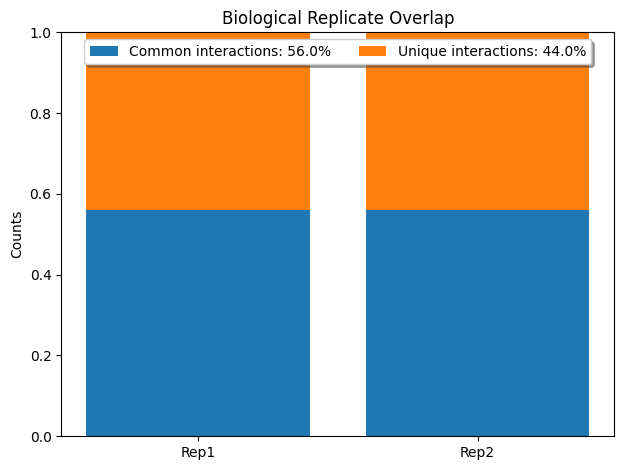

In [57]:
%matplotlib inline
labels = ["Rep1","Rep2"]
men_means = [round(common.shape[0]/50,3),round(common.shape[0]/50,3)]
women_means = [1- round(common.shape[0]/50,3),1- round(common.shape[0]/50,3)]
width = 0.35       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots()

ax.bar(labels, men_means, label=f"Common interactions: {round(common.shape[0]/50*100,2)}%")
ax.bar(labels, women_means, bottom=men_means,
       label=f"Unique interactions: {round(100-round(common.shape[0]/50*100,3),2)}%")

ax.set_ylabel("Counts")
ax.set_title("Biological Replicate Overlap")
ax.set_ylim((0,1))
ax.legend(loc='upper center',
          ncol=3, fancybox=True, shadow=True)
plt.tight_layout()
#plt.savefig("/results/bio_rep.png")
plt.show()


### find the number of common interactions within the top 100 between pre and post treatment datasets (and save that value for the randomization experiment)

In [58]:
pre_post_common = pd.merge(day0.head(50),day7_rep1.head(50))

In [59]:
pre_post_common.shape[0]/50

0.16

### use a stacked bar plot to visualize the commonalities

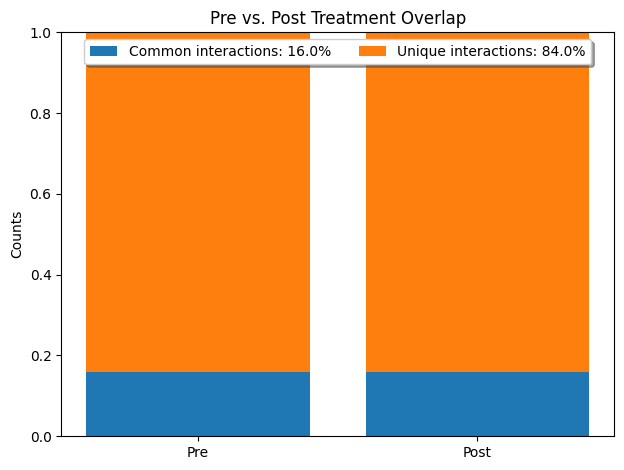

In [60]:
%matplotlib inline
labels = ["Pre","Post"]
men_means = [round(pre_post_common.shape[0]/50,3),round(pre_post_common.shape[0]/50,3)]
women_means = [1- round(pre_post_common.shape[0]/50,3),1- round(pre_post_common.shape[0]/50,3)]
width = 0.35       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots()

ax.bar(labels, men_means, label=f"Common interactions: {round(pre_post_common.shape[0]/50*100,3)}%")
ax.bar(labels, women_means, bottom=men_means,
       label=f"Unique interactions: {round(100-round(pre_post_common.shape[0]/50*100,3),2)}%")

ax.set_ylabel("Counts")
ax.set_title("Pre vs. Post Treatment Overlap")
ax.set_ylim((0,1))
ax.legend(loc='upper center',
          ncol=3, fancybox=True, shadow=True)
plt.tight_layout()
#plt.savefig("/results/bio_rep.png")
plt.show()


In [61]:
difference_accuracy = original_accuracy - pre_post_common.shape[0]/50

In [89]:
df = pd.merge(common, pre_post_common, on=['Src','Dst'], how='left', indicator='Exist')

## Compare difference between overlap biological replicates vs. pre and post for Original Set and 100 Randomized Interactions

### load the datasets

In [64]:
rep1_list = []
rep2_list = []
day_0_list = []
for i in range(0,100):
    day_0_list.append(pd.read_csv(f"/data/random_data/Pre_Post/Day0_{i+1}_random.csv",index_col=0)[["Src","Dst"]])
    rep1_list.append(pd.read_csv(f"/data/random_data/Pre_Post/Rep1_{i+1}_random.csv",index_col=0)[["Src","Dst"]])
    rep2_list.append(pd.read_csv(f"/data/random_data/Pre_Post/Rep2_{i+1}_random.csv",index_col=0)[["Src","Dst"]])

In [65]:
Omnipath_database = pd.read_csv("../../data/LR_database/intercell_Omnipath.csv",index_col=0)[["source_genesymbol","target_genesymbol"]].drop_duplicates()
Omnipath_database.columns = ["from","to"]

#### within each randomized Rep1 and Rep2, subset for validated intercell interactions

In [66]:
day_0_list = [pd.merge(i,Omnipath_database,left_on=["Src","Dst"],right_on=["from","to"]) for i in day_0_list]

In [67]:
rep1_list = [pd.merge(i,Omnipath_database,left_on=["Src","Dst"],right_on=["from","to"]) for i in rep1_list]

In [68]:
rep2_list = [pd.merge(i,Omnipath_database,left_on=["Src","Dst"],right_on=["from","to"]) for i in rep2_list]

In [69]:
day_0_list = [i[["Src","Dst"]] for i in day_0_list]
rep1_list = [i[["Src","Dst"]] for i in rep1_list]
rep2_list = [i[["Src","Dst"]] for i in rep2_list]

In [70]:
rep_merged_list = [pd.merge(i.head(50),j.head(50)) for i,j in zip(rep1_list,rep2_list)]

In [71]:
pre_post_merged_list = [pd.merge(i.head(50),j.head(50)) for i,j in zip(day_0_list,rep2_list)]

### find the difference in overlap between each biological replicates and pre and post treatment

In [72]:
difference_list = [abs((i.shape[0]/50) - (j.shape[0]/50)) for i,j in zip(rep_merged_list,pre_post_merged_list)]

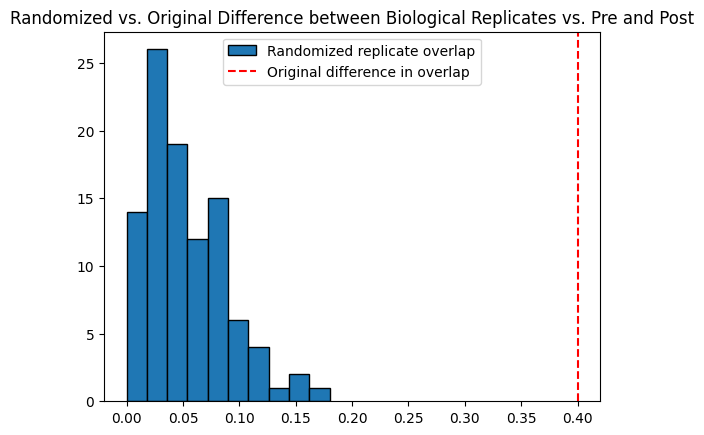

In [73]:
plt.hist(difference_list,edgecolor='black',rwidth=1,label="Randomized replicate overlap")
plt.axvline(difference_accuracy,linestyle="--",color="red",label="Original difference in overlap")
plt.title("Randomized vs. Original Difference between Biological Replicates vs. Pre and Post")
plt.legend()

## Compare overlap between biological replicates for Original Set and 100 Randomized Interactions

### find the fraction of overlap between each set of replicates

In [74]:
accuracy_list = [i.shape[0]/50 for i in rep_merged_list]

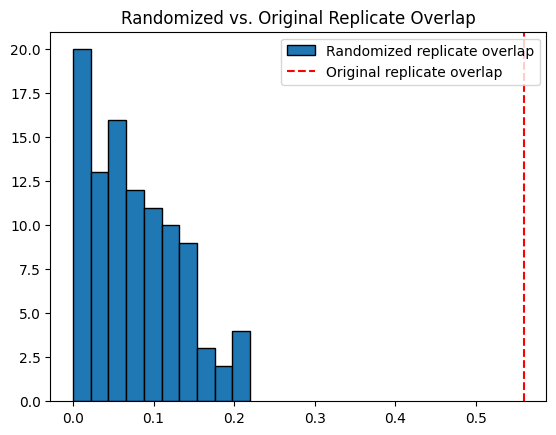

In [75]:
plt.hist(accuracy_list,edgecolor='black',rwidth=1,label="Randomized replicate overlap")
plt.axvline(original_accuracy,linestyle="--",color="red",label="Original replicate overlap")
plt.title("Randomized vs. Original Replicate Overlap")
plt.legend(loc="upper right")

# Dataset 5: Spatial Cardiovascular Data (Figure 6 & 7)

## Find most common interacting cell groups and spatial adjacency across all fibrotic and ischemic slides (Fig 4 B-G)

In [109]:
fibrotic_list = []
for i in os.listdir("../../data/GraphComm_Output/Cardiac_cells/"):
    if "FZ" in i:
        temp_df = pd.read_csv(f"../../data/GraphComm_Output/Cardiac_cells/{i}/CCI.csv",index_col=0)
        fibrotic_list.append(temp_df)
fibrotic_CCI = pd.concat(fibrotic_list)

In [110]:
ischemic_list = []
for i in os.listdir("../../data/GraphComm_Output/Cardiac_cells/"):
    if "IZ" in i:
        temp_df = pd.read_csv(f"../../data/GraphComm_Output/Cardiac_cells/{i}/CCI.csv",index_col=0)
        ischemic_list.append(temp_df)
ischemic_CCI = pd.concat(ischemic_list)

## remove self-loops

In [111]:
fibrotic_list = [i[i["Src Cell"] != i["Dst Cell"]] for i in fibrotic_list]
ischemic_list = [j[j["Src Cell"] != j["Dst Cell"]] for j in ischemic_list]

## from each slide, retain the top 100 interactions

In [112]:
fibrotic_CCI = pd.concat(fibrotic_list)
ischemic_CCI = pd.concat(ischemic_list)

In [113]:
fibrotic_CCI = pd.concat([i.head(100) for i in fibrotic_list])
ischemic_CCI = pd.concat([i.head(100) for i in ischemic_list])

In [114]:
fibrotic_CCI = fibrotic_CCI.sort_values("Prob",ascending=False)
ischemic_CCI = ischemic_CCI.sort_values("Prob",ascending=False)

In [115]:
fibrotic_cell_groups = list(set(fibrotic_CCI["Src Cell"].unique().tolist() + fibrotic_CCI["Dst Cell"].unique().tolist()))
ischemic_cell_groups = list(set(ischemic_CCI["Src Cell"].unique().tolist() + ischemic_CCI["Dst Cell"].unique().tolist()))

In [116]:
fibrotic_matrix = pd.DataFrame(index=fibrotic_cell_groups,columns=fibrotic_cell_groups)
ischemic_matrix = pd.DataFrame(index=ischemic_cell_groups,columns=ischemic_cell_groups)

In [117]:
fibrotic_CCI = fibrotic_CCI[["Src Cell","Dst Cell","Prob"]]
ischemic_CCI = ischemic_CCI[["Src Cell","Dst Cell","Prob"]]

In [118]:
fibrotic_CCI = fibrotic_CCI.groupby(["Src Cell","Dst Cell"]).count()
ischemic_CCI = ischemic_CCI.groupby(["Src Cell","Dst Cell"]).count()

In [119]:
fibrotic_matrix = fibrotic_matrix.fillna(0)
ischemic_matrix = ischemic_matrix.fillna(0)

In [120]:
for index,row in fibrotic_CCI.iterrows():
    fibrotic_matrix.loc[index[0],index[1]] += row["Prob"]
    fibrotic_matrix.loc[index[1],index[0]] += row["Prob"]

In [121]:
for index,row in ischemic_CCI.iterrows():
    ischemic_matrix.loc[index[0],index[1]] += row["Prob"]
    ischemic_matrix.loc[index[1],index[0]] += row["Prob"]

In [122]:
fibrotic_matrix = fibrotic_matrix.fillna(0)
ischemic_matrix = ischemic_matrix.fillna(0)

In [123]:
fibrotic_matrix

,Myeloid,Fibroblast,Mast,Cardiomyocyte,Pericyte,vSMCs,Neuronal,Endothelial,Cycling.cells
Myeloid,0,4,4,0,0,108,5,14,25
Fibroblast,4,0,3,0,0,13,3,3,10
Mast,4,3,0,26,0,46,1,3,43
Cardiomyocyte,0,0,26,0,0,26,0,0,11
Pericyte,0,0,0,0,0,39,0,0,0
vSMCs,108,13,46,26,39,0,36,22,44
Neuronal,5,3,1,0,0,36,0,1,100
Endothelial,14,3,3,0,0,22,1,0,10
Cycling.cells,25,10,43,11,0,44,100,10,0


In [124]:
import numpy as np

In [125]:
import seaborn as sns

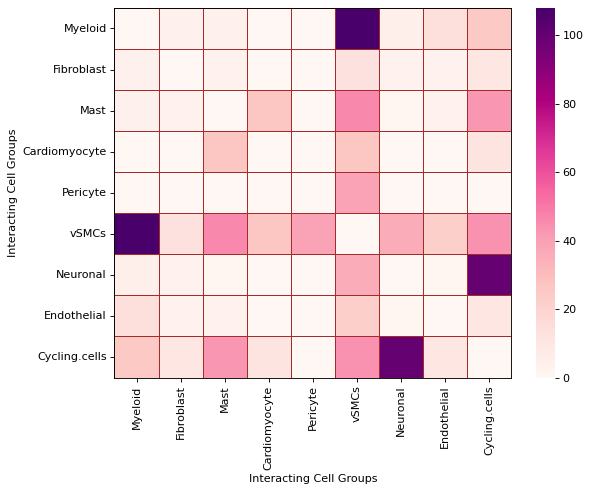

In [126]:
%matplotlib inline
figure(figsize=(8, 6), dpi=80)
ax = sns.heatmap(fibrotic_matrix,cmap="RdPu",linewidths=0.5, linecolor='brown')
ax.set_xlabel("Interacting Cell Groups")
ax.set_ylabel("Interacting Cell Groups")
for _, spine in ax.spines.items():
    spine.set_visible(True)

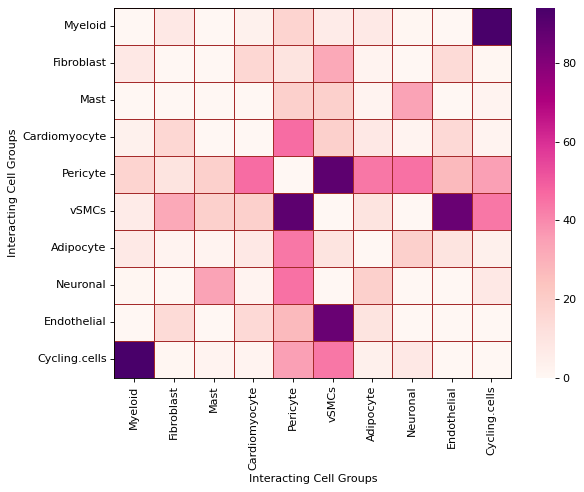

In [127]:
%matplotlib inline
figure(figsize=(8, 6), dpi=80)

ax = sns.heatmap(ischemic_matrix,cmap="RdPu",linewidths=0.5, linecolor='brown')
ax.set_xlabel("Interacting Cell Groups")
ax.set_ylabel("Interacting Cell Groups")
for _, spine in ax.spines.items():
    spine.set_visible(True)

# Comparison of spatial adjacency in a given fibrotic slide (visualize abundant/scarce cell group interaction spatially)

## Example visualization of abundant interaction

In [128]:
adata = sc.read_h5ad("/data/raw_data/Cardiac_cells/Visium-FZ_GT_P19.h5ad")
original_meta = pd.DataFrame({"cell":adata.obs.index.tolist(),"labels":adata.obs["cell_type_original"].tolist()})

In [129]:
groups = ["vSMCs","Myeloid"]
colour_dict = {groups[0]:"red",groups[1]:"blue"}

In [130]:
unique_cells = adata.obs[adata.obs['cell_type_original'].isin(groups)].index.tolist()
unique_cells = list(set(unique_cells))
meta = pd.DataFrame({"cell":adata.obs.index.tolist(),"labels":adata.obs["cell_type_original"].tolist()})
adata = adata[unique_cells]
meta.index = meta["cell"].tolist()

/opt/conda/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


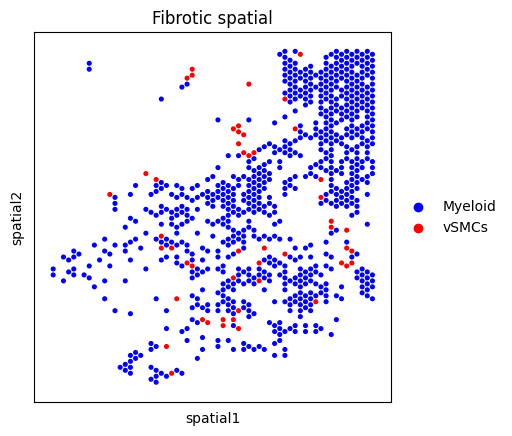

In [131]:
sc.pl.spatial(adata,img_key=None,spot_size=0.015,color="cell_type_original",palette=colour_dict,title="Fibrotic spatial")


## identify validated ligand-receptor pairs that occur in abundant cell group interaction

In [132]:
fibrotic_ints = pd.concat(fibrotic_list)

In [352]:
one="Myeloid"
two="vSMCs"

In [134]:
fibrotic_ints = fibrotic_ints[((fibrotic_ints["Src Cell"]==one)&(fibrotic_ints["Dst Cell"]==two)) | ((fibrotic_ints["Dst Cell"]==one)&(fibrotic_ints["Src Cell"]==two))]

In [135]:
consensus = pd.read_csv("/data/LR_database/intercell_Omnipath.csv",index_col=0)

In [136]:
fibrotic_ints = pd.merge(fibrotic_ints,consensus,left_on=["Src","Dst"],right_on=["source_genesymbol","target_genesymbol"])

In [137]:
fibrotic_ints.head()

,Src,Dst,Prob,Src Cell,Dst Cell,source_genesymbol,target_genesymbol,references
0,ANXA1,FPR3,0.711193,vSMCs,Myeloid,ANXA1,FPR3,CellTalkDB:15187149;Cellinker:15187149;Guide2P...
1,VIP,NPR3,0.680561,vSMCs,Myeloid,VIP,NPR3,CellTalkDB:16723209
2,ADCYAP1,VIPR1,0.680232,Myeloid,vSMCs,ADCYAP1,VIPR1,Baccin2019:11897681;Baccin2019:11931347;Baccin...
3,ADCYAP1,DPP4,0.680181,Myeloid,vSMCs,ADCYAP1,DPP4,Cellinker:21314817
4,ADCYAP1,DPP4,0.103202,vSMCs,Myeloid,ADCYAP1,DPP4,Cellinker:21314817


## Example visualization of scarce interaction

In [138]:
adata = sc.read_h5ad("/data/raw_data/Cardiac_cells/Visium-FZ_P14.h5ad")
original_meta = pd.DataFrame({"cell":adata.obs.index.tolist(),"labels":adata.obs["cell_type_original"].tolist()})

In [139]:
groups = ["Cycling.cells","Mast"]
colour_dict = {groups[0]:"red",groups[1]:"blue"}

In [140]:
unique_cells = adata.obs[adata.obs['cell_type_original'].isin(groups)].index.tolist()
unique_cells = list(set(unique_cells))
meta = pd.DataFrame({"cell":adata.obs.index.tolist(),"labels":adata.obs["cell_type_original"].tolist()})
adata = adata[unique_cells]
meta.index = meta["cell"].tolist()

/opt/conda/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


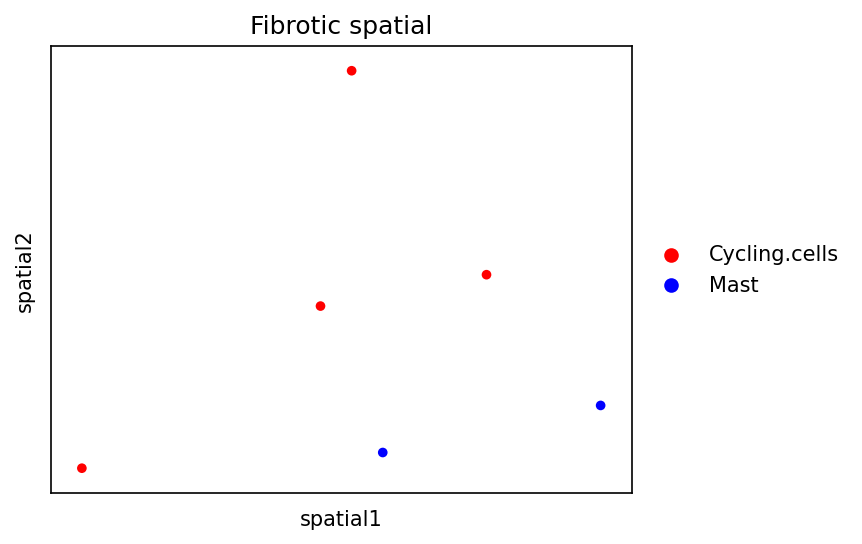

In [141]:
%matplotlib inline
with plt.rc_context({"figure.figsize": (5, 5), "figure.dpi": (150)}):
    sc.pl.spatial(adata,img_key=None,spot_size=0.015,color="cell_type_original",title="Fibrotic spatial",palette=colour_dict)

# Comparison of spatial adjacency in a given ischemic slide (visualize abundant/scarce cell group interaction spatially)

## Example visualization of abundant interaction

In [194]:
adata = sc.read_h5ad("/data/raw_data/Cardiac_cells/Visium-IZ_P3.h5ad")
original_meta = pd.DataFrame({"cell":adata.obs.index.tolist(),"labels":adata.obs["cell_type_original"].tolist()})

In [195]:
groups = ["vSMCs","Endothelial"]
colour_dict = {groups[0]:"red",groups[1]:"blue"}

In [196]:
unique_cells = adata.obs[adata.obs['cell_type_original'].isin(groups)].index.tolist()
unique_cells = list(set(unique_cells))
meta = pd.DataFrame({"cell":adata.obs.index.tolist(),"labels":adata.obs["cell_type_original"].tolist()})
adata = adata[unique_cells]

/opt/conda/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


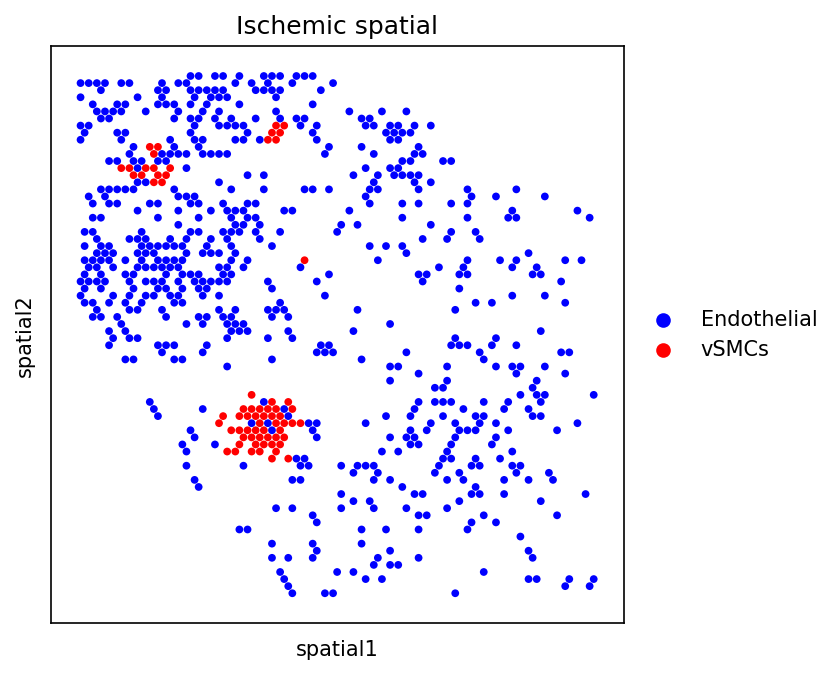

In [197]:
%matplotlib inline
with plt.rc_context({"figure.figsize": (5, 5), "figure.dpi": (150)}):
    sc.pl.spatial(adata,img_key=None,spot_size=0.015,color="cell_type_original",color_map="viridis",title="Ischemic spatial",palette=colour_dict)

## Example visualization of scarce interaction

In [168]:
adata = sc.read_h5ad("/data/raw_data/Cardiac_cells/Visium-IZ_BZ_P2.h5ad")
original_meta = pd.DataFrame({"cell":adata.obs.index.tolist(),"labels":adata.obs["cell_type_original"].tolist()})

In [169]:
groups = ["Adipocyte","Mast"]
colour_dict = {groups[0]:"red",groups[1]:"blue"}

In [170]:
unique_cells = adata.obs[adata.obs['cell_type_original'].isin(groups)].index.tolist()
unique_cells = list(set(unique_cells))
meta = pd.DataFrame({"cell":adata.obs.index.tolist(),"labels":adata.obs["cell_type_original"].tolist()})
adata = adata[unique_cells]
meta.index = meta["cell"].tolist()

/opt/conda/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


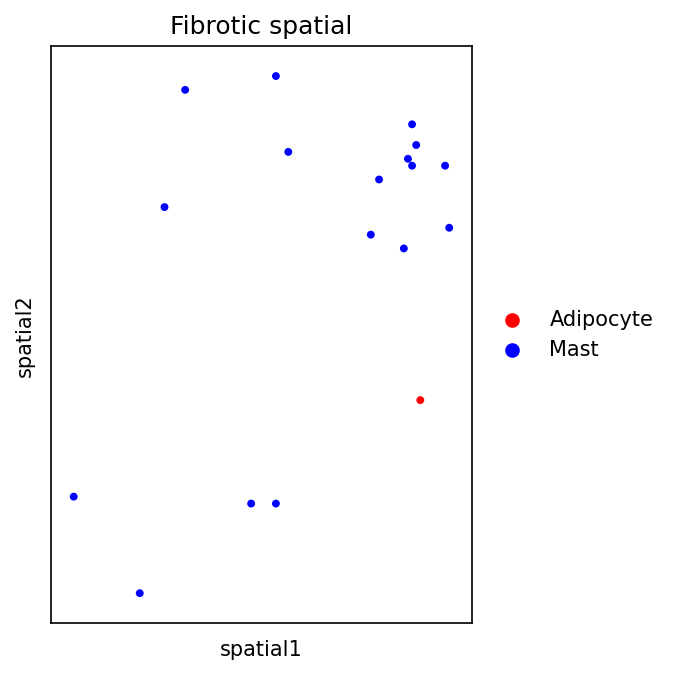

In [171]:
%matplotlib inline
with plt.rc_context({"figure.figsize": (5, 5), "figure.dpi": (150)}):
    sc.pl.spatial(adata,img_key=None,spot_size=0.015,color="cell_type_original",title="Fibrotic spatial",palette=colour_dict)

## identify validated ligand-receptor pairs that occur in abundant cell group interaction

In [198]:
ischemic_ints = pd.concat(ischemic_list)

In [199]:
one="vSMCs"
two="Endothelial"

In [200]:
ischemic_ints = ischemic_ints[((ischemic_ints["Src Cell"]==one)&(ischemic_ints["Dst Cell"]==two)) | ((ischemic_ints["Dst Cell"]==one)&(ischemic_ints["Src Cell"]==two))]

In [201]:
consensus = pd.read_csv("/data/LR_database/intercell_Omnipath.csv",index_col=0)

In [202]:
ischemic_ints = pd.merge(ischemic_ints,consensus,left_on=["Src","Dst"],right_on=["source_genesymbol","target_genesymbol"])

In [203]:
ischemic_ints.sort_values("Prob",ascending=False).head(10)

,Src,Dst,Prob,Src Cell,Dst Cell,source_genesymbol,target_genesymbol,references
0,SLIT3,ROBO4,0.957123,vSMCs,Endothelial,SLIT3,ROBO4,Cellinker:30288875;connectomeDB2020:19741192
47,VWF,SCARA5,0.934350,Endothelial,vSMCs,VWF,SCARA5,CellTalkDB:31126000
85,POMC,GPR20,0.905295,Endothelial,vSMCs,POMC,GPR20,CellTalkDB:32196115
33,EDN1,ADGRL4,0.903241,vSMCs,Endothelial,EDN1,ADGRL4,CellTalkDB:32196115
86,FGF13,SCN9A,0.897228,vSMCs,Endothelial,FGF13,SCN9A,SIGNOR:20679355
3,FGF13,SCN3A,0.858228,Endothelial,vSMCs,FGF13,SCN3A,SIGNOR:20679355
4,EBI3,IL27RA,0.858022,Endothelial,vSMCs,EBI3,IL27RA,Baccin2019:12121660;CellTalkDB:12121660;HPRD:1...
5,TGFB2,TGFBR3,0.856880,Endothelial,vSMCs,TGFB2,TGFBR3,Baccin2019:11157750;Baccin2019:12809600;CellTa...
54,FYN,PLD2,0.848639,Endothelial,vSMCs,FYN,PLD2,HPRD:12697812;KEA:15282299;KEA:9837959;SPIKE_L...
7,GSTO1,RYR1,0.819572,vSMCs,Endothelial,GSTO1,RYR1,CellTalkDB:11035031


# Analysis of single slide *FZ_GT_P19*

### visualize the total spatial map of tissue

In [420]:
input_data = pd.read_csv("../../data/GraphComm_Output/Cardiac_cells/FZ_GT_P19/CCI.csv",index_col=0)
input_data.index = range(0,input_data.shape[0])

In [367]:
adata = sc.read_h5ad("../../data/raw_data/Cardiac_cells/Visium-FZ_GT_P19.h5ad")
original_meta = pd.DataFrame({"cell":adata.obs.index.tolist(),"labels":adata.obs["cell_type_original"].tolist()})

### subset for **only validated intercell interactions**, and remove any self loops

In [421]:
input_data = input_data[input_data["Src Cell"] != input_data["Dst Cell"]]
unique_groups = input_data.drop_duplicates(["Src Cell","Dst Cell"])

In [369]:
intercell_network = pd.read_csv("../../data/LR_database/intercell_Omnipath.csv",index_col=0)

In [370]:
intercell_network.columns = ["source_genesymbol","target_genesymbol","refs"]

In [371]:
input_data.head(15)

,Src,Dst,Prob,Src Cell,Dst Cell
0,ACTB,MGP,1.000000,vSMCs,Mast
1,ACTB,MYL2,0.996975,vSMCs,Pericyte
2,ACTB,FTL,0.996022,vSMCs,Myeloid
3,ACTB,FTH1,0.992287,vSMCs,Myeloid
4,ACTB,TPT1,0.987649,vSMCs,Mast
5,ACTB,ACTA1,0.980325,vSMCs,Cardiomyocyte
6,ACTB,TPM1,0.974315,vSMCs,Pericyte
7,ACTB,DES,0.966091,vSMCs,Pericyte
9,ACTB,TNNI3,0.943357,vSMCs,Cardiomyocyte
10,ACTB,ACTC1,0.938778,vSMCs,Cardiomyocyte


In [422]:
input_data.tail(25)

,Src,Dst,Prob,Src Cell,Dst Cell
6840162,CNKSR1,RAPSN,0.019307,Cardiomyocyte,Endothelial
6840163,CD96,TRIM9,0.019300,Fibroblast,vSMCs
6840164,DSC1,STX1A,0.019290,Cardiomyocyte,Fibroblast
6840165,ESRRB,GCK,0.019267,Fibroblast,Cardiomyocyte
6840166,ESRRB,RAPSN,0.019251,Fibroblast,Endothelial
6840167,CNKSR1,KIF23,0.019249,Cardiomyocyte,Endothelial
6840168,CNKSR1,STX1A,0.019228,Cardiomyocyte,Fibroblast
6840169,CD226,KCNJ3,0.019199,vSMCs,Cardiomyocyte
6840170,ESRRB,KIF23,0.019193,Fibroblast,Endothelial
6840171,DSC1,SEPTIN3,0.019183,Cardiomyocyte,vSMCs


## generate table for Cytoscape network

### list top ranked or low ranked interactions

## identify patterns in cell group interactions in only validated LR pairs

In [425]:
top_input = input_data.head(1000)

In [426]:
top_input = top_input.groupby(["Src Cell","Dst Cell"]).sum("Prob")

In [427]:
top_input

Prob
Src Cell      Dst Cell                 
Cardiomyocyte Mast             0.562799
              Myeloid          0.560372
              Pericyte         0.560953
Fibroblast    Cardiomyocyte    0.575472
              Mast             2.293334
              Myeloid          1.729446
              Pericyte         2.285732
              vSMCs            0.565339
Mast          Cardiomyocyte    2.275672
              Myeloid          2.337747
              Pericyte         2.334230
              vSMCs            0.577099
Myeloid       Mast             0.563471
              Pericyte         0.561624
Neuronal      Mast             0.567896
              Myeloid          1.128605
              Pericyte         0.566036
Pericyte      Cardiomyocyte    0.563393
              Mast             1.706482
              Myeloid          1.704464
vSMCs         Cardiomyocyte   59.245614
              Endothelial     43.211264
              Fibroblast       5.883949
              Mast           144.685201
              Myeloid         23.678888
              Neuronal       172.801047
              Pericyte       184.625635

In [428]:
top_input = top_input.sort_values("Prob",ascending=False)

In [429]:
os.system("mkdir -p /results/GraphComm_Output/Cardiac_cells/")

0

In [382]:
top_input.to_csv("/results/GraphComm_Output/Cardiac_cells/FZ_GT_P19_grouped.csv")

## Visualize top ranked interaction

In [415]:
input_data = pd.merge(input_data,intercell_network,left_on=["Src","Dst"],right_on=["source_genesymbol","target_genesymbol"])

In [384]:
adata = sc.read_h5ad("../../data/raw_data/Cardiac_cells/Visium-FZ_GT_P19.h5ad")
original_meta = pd.DataFrame({"cell":adata.obs.index.tolist(),"labels":adata.obs["cell_type_original"].tolist()})

In [385]:
groups = ["Myeloid","vSMCs"]
colour_dict = {groups[0]:"red",groups[1]:"blue"}

In [386]:
unique_cells = adata.obs[adata.obs['cell_type_original'].isin(groups)].index.tolist()
unique_cells = list(set(unique_cells))
meta = pd.DataFrame({"cell":adata.obs.index.tolist(),"labels":adata.obs["cell_type_original"].tolist()})
adata = adata[unique_cells]
adata.obs["barcode"] = adata.obs.index.tolist()
adata.obs["barcode"] = adata.obs["barcode"].astype('category')

<ipython-input-386-9e23e81246f9>:5: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["barcode"] = adata.obs.index.tolist()


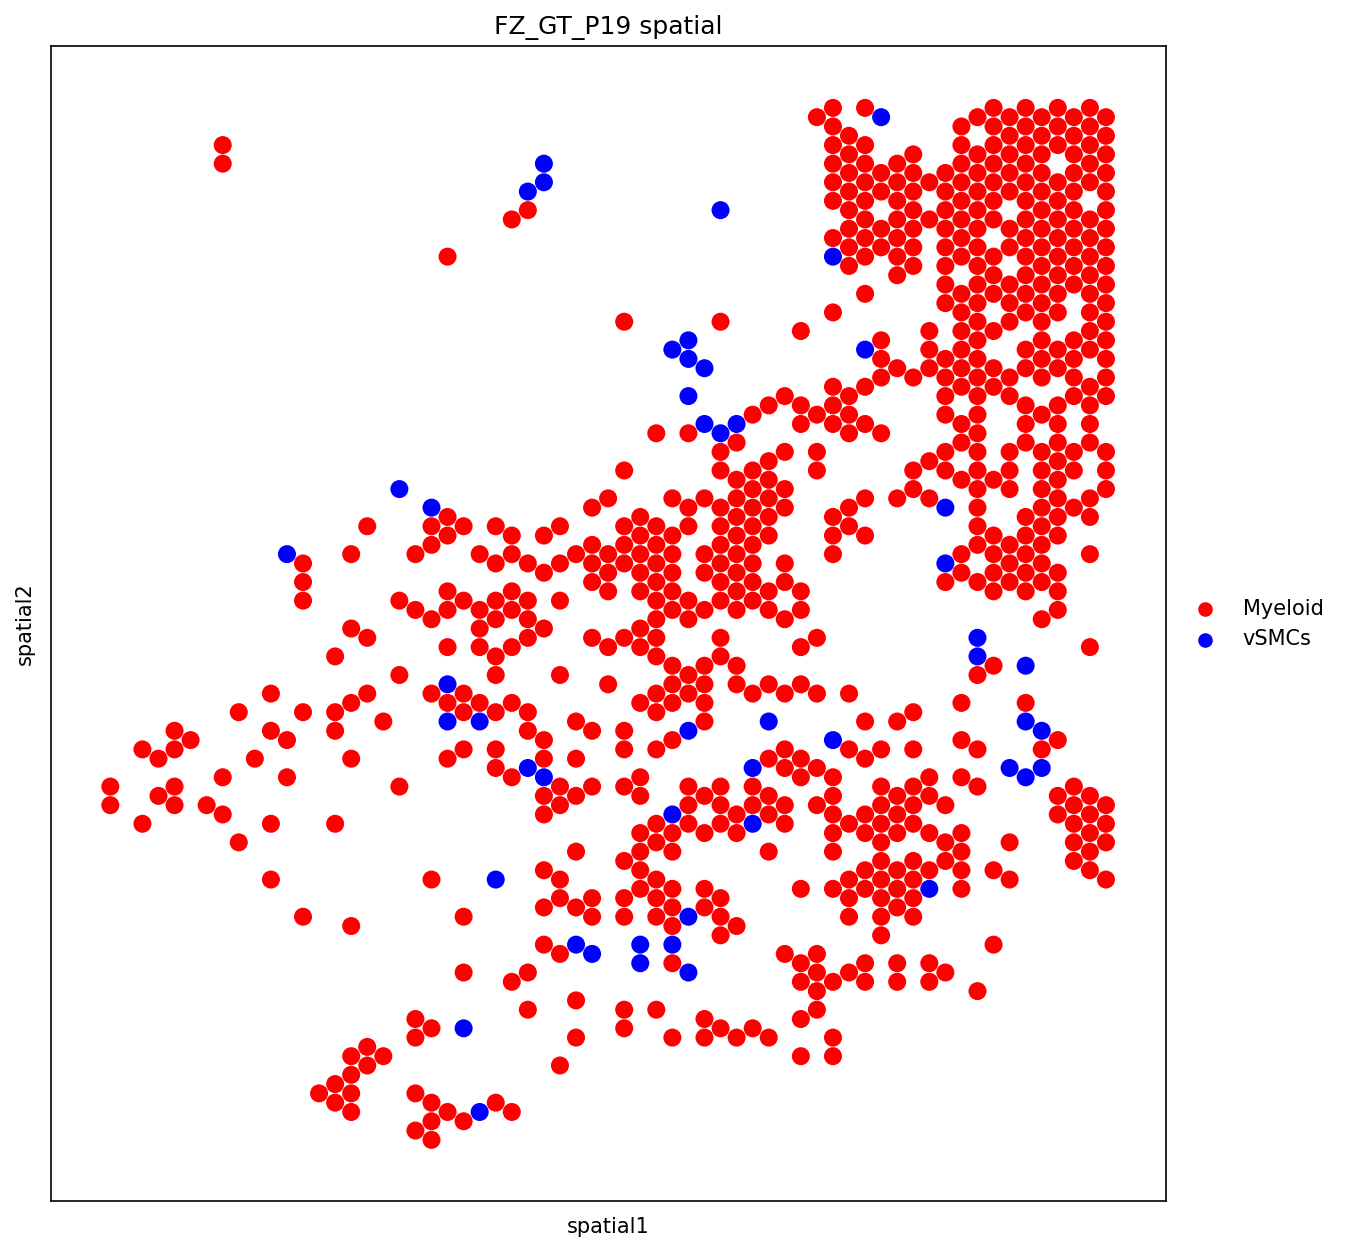

In [387]:
%matplotlib inline
with plt.rc_context({"figure.figsize": (10, 10), "figure.dpi": (150)}):
    sc.pl.spatial(adata,img_key=None,spot_size=0.017,scale_factor=1,color="cell_type_original",title="FZ_GT_P19 spatial",palette=colour_dict)

In [388]:
new_meta = meta[(meta["labels"]=="vSMCs") | (meta["labels"]=="Myeloid")]

In [389]:
spatial_coordinates = adata.obsm["X_spatial"]
spatial_df = pd.DataFrame({"x":spatial_coordinates[:,0],"y":spatial_coordinates[:,1]},index=new_meta.index.tolist())

In [412]:
one="vSMCs"
two="Myeloid"

In [417]:
relevant_input = input_data[((input_data["Src Cell"]==one)&(input_data["Dst Cell"]==two)) | ((input_data["Dst Cell"]==one)&(input_data["Src Cell"]==two))]






In [418]:
relevant_input

,Src,Dst,Prob,Src Cell,Dst Cell,source_genesymbol,target_genesymbol,refs
28,HLA-B,SIGLEC10,0.267965,Myeloid,vSMCs,HLA-B,SIGLEC10,Cellinker:32822567
75,HP,CD163,0.198451,vSMCs,Myeloid,HP,CD163,CellTalkDB:25389409;HPRD:11854028;connectomeDB...
82,CXCL12,DPP4,0.188095,vSMCs,Myeloid,CXCL12,DPP4,CellTalkDB:30759373;Cellinker:11390394;HPRD:11...
160,SIGLEC9,ADGRA2,0.132870,Myeloid,vSMCs,SIGLEC9,ADGRA2,Cellinker:32822567
174,CD52,SIGLEC10,0.127698,Myeloid,vSMCs,CD52,SIGLEC10,Cellinker:23685786;LRdb:23685786;connectomeDB2...
183,KITLG,LRRN3,0.125011,vSMCs,Myeloid,KITLG,LRRN3,Cellinker:32589946
214,SIGLEC9,SIGLEC10,0.103594,Myeloid,vSMCs,SIGLEC9,SIGLEC10,Cellinker:32822567
215,ADCYAP1,DPP4,0.103202,vSMCs,Myeloid,ADCYAP1,DPP4,Cellinker:21314817
217,GDNF,GFRA3,0.102893,Myeloid,vSMCs,GDNF,GFRA3,CellTalkDB:32196115


## calculate mean eucledian distance between all spots of cell groups

In [390]:
import math

In [391]:
total_list = []
data_list = []
one = "vSMCs"
two = "Myeloid"
cells = new_meta[new_meta["labels"]==one].index.tolist()
spatial_coords = [(i,j) for i,j in zip(spatial_df.loc[cells]["x"].tolist(),spatial_df.loc[cells]["y"].tolist())]
#if two != one:
second_cells = new_meta[new_meta["labels"]==two].index.tolist()
second_spatial_coords = [(i,j) for i,j in zip(spatial_df.loc[second_cells]["x"].tolist(),spatial_df.loc[second_cells]["y"].tolist())]
min_list = []
for k in spatial_coords:
    min_list.append(np.mean([math.dist(k,l) for l in second_spatial_coords]))
data_list.append(np.mean(min_list))


In [392]:
data_list

[0.4143414475594602]

## Visualize low-ranked interaction

In [402]:
adata = sc.read_h5ad("../../data/raw_data/Cardiac_cells/Visium-FZ_GT_P19.h5ad")
original_meta = pd.DataFrame({"cell":adata.obs.index.tolist(),"labels":adata.obs["cell_type_original"].tolist()})

In [403]:
groups = ["Cardiomyocyte","Endothelial"]
colour_dict = {groups[0]:"red",groups[1]:"blue"}

In [404]:
unique_cells = adata.obs[adata.obs['cell_type_original'].isin(groups)].index.tolist()
unique_cells = list(set(unique_cells))
meta = pd.DataFrame({"cell":adata.obs.index.tolist(),"labels":adata.obs["cell_type_original"].tolist()})
adata = adata[unique_cells]
adata.obs["barcode"] = adata.obs.index.tolist()
adata.obs["barcode"] = adata.obs["barcode"].astype('category')

<ipython-input-404-9e23e81246f9>:5: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["barcode"] = adata.obs.index.tolist()


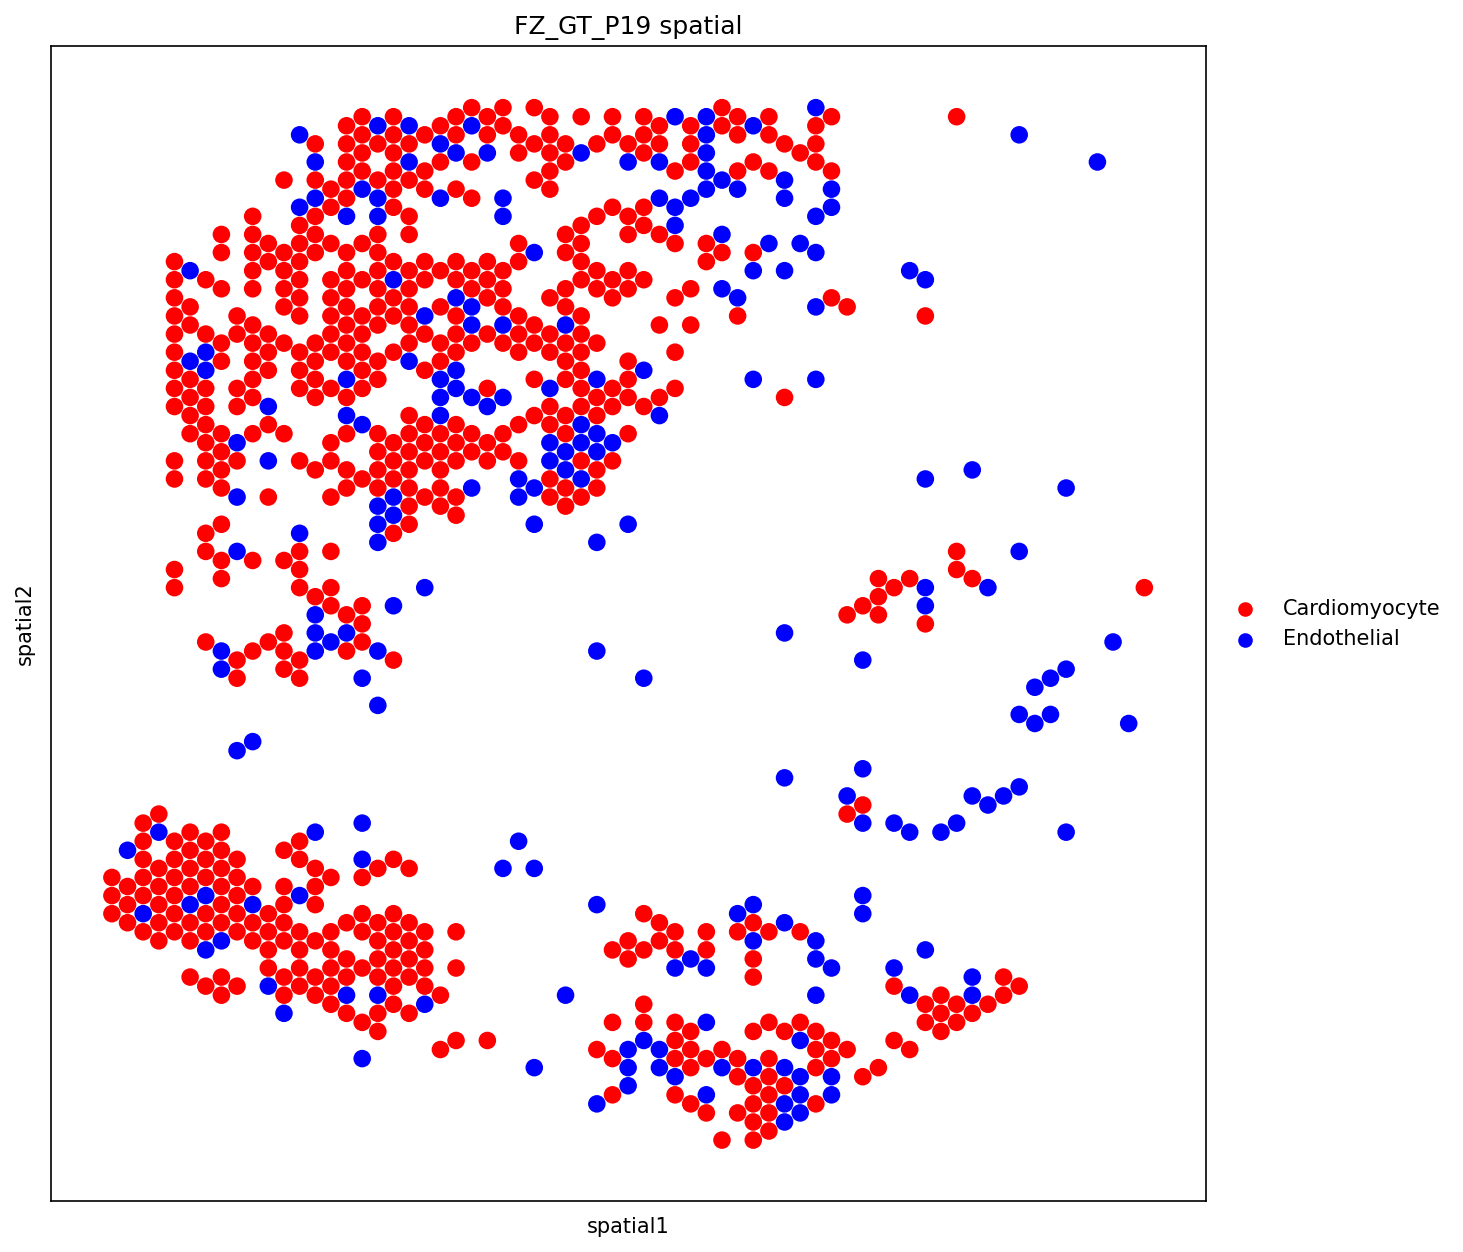

In [405]:
%matplotlib inline
with plt.rc_context({"figure.figsize": (10, 10), "figure.dpi": (150)}):
    sc.pl.spatial(adata,img_key=None,spot_size=0.017,scale_factor=1,color="cell_type_original",title="FZ_GT_P19 spatial",palette=colour_dict)

In [406]:
one = "Cardiomyocyte"
two = "Endothelial"

In [407]:
new_meta = meta[(meta["labels"]==one) | (meta["labels"]==two)]

In [408]:
spatial_coordinates = adata.obsm["X_spatial"]
spatial_df = pd.DataFrame({"x":spatial_coordinates[:,0],"y":spatial_coordinates[:,1]},index=new_meta.index.tolist())

In [409]:
import math

In [410]:
total_list = []
data_list = []
cells = new_meta[new_meta["labels"]==one].index.tolist()
spatial_coords = [(i,j) for i,j in zip(spatial_df.loc[cells]["x"].tolist(),spatial_df.loc[cells]["y"].tolist())]
#if two != one:
second_cells = new_meta[new_meta["labels"]==two].index.tolist()
second_spatial_coords = [(i,j) for i,j in zip(spatial_df.loc[second_cells]["x"].tolist(),spatial_df.loc[second_cells]["y"].tolist())]
min_list = []
for k in spatial_coords:
    min_list.append(np.mean([math.dist(k,l) for l in second_spatial_coords]))
data_list.append(np.mean(min_list))
total_list.append(data_list)


In [411]:
data_list

[0.4800172957030988]

## Getting interactions from SCLC xenografts (Supplementary Tables)

In [28]:
pre_naive = pd.read_csv("/results/GraphComm_Output/Pre_Post/GSE138267/GSM4104147_SC39.LB17019/CCI.csv")
pre_resistant = pd.read_csv("/results/GraphComm_Output/Pre_Post/GSE138267/GSM4104163_SC55.LB19001/CCI.csv")
post_naive = pd.read_csv("/results/GraphComm_Output/Pre_Post/GSE138267/GSM4104164_SC68_cr.LB19003/CCI.csv")
post_resistant = pd.read_csv("/results/GraphComm_Output/Pre_Post/GSE138267/GSM4104156_SC55-2.LB17002/CCI.csv")

In [29]:
intercell = pd.read_csv("/data/LR_database/intercell_Omnipath.csv",index_col=0)
intercell.columns = ["from","to","sources"]

In [30]:
pre_naive = pre_naive[pre_naive["Src"].isin(intercell["from"].tolist()) & pre_naive["Dst"].isin(intercell["to"].tolist())]
pre_resistant = pre_resistant[pre_resistant["Src"].isin(intercell["from"].tolist()) & pre_resistant["Dst"].isin(intercell["to"].tolist())]
post_naive = post_naive[post_naive["Src"].isin(intercell["from"].tolist()) & post_naive["Dst"].isin(intercell["to"].tolist())]
post_resistant = post_resistant[post_resistant["Src"].isin(intercell["from"].tolist()) & post_resistant["Dst"].isin(intercell["to"].tolist())]

In [31]:
pre_naive.head(500).to_csv("/results/pre_naive.csv")
pre_resistant.head(500).to_csv("/results/pre_resistant.csv")
post_naive.head(500).to_csv("/results/post_naive.csv")
post_resistant.head(500).to_csv("/results/post_resistant.csv")

In [32]:
post_resistant.head(50)

,Unnamed: 0,Src,Dst,Prob
155,132914,ACTR2,APP,0.743129
157,161968,HLA-DMB,APP,0.743120
158,159580,ICAM3,APP,0.743119
192,77194,KMT2E,APP,0.742757
399,157590,OXT,APP,0.627564
442,165152,GRN,APP,0.627230
554,98686,TP53,APP,0.609509
674,145252,HSPA8,APP,0.602638
1714,133710,VEGFB,APP,0.588962
1718,39782,IL32,APP,0.588919


In [ ]:
categories = omnipath.interactions.ct